In [1]:
import numpy as np
import cv2 as cv
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imutils
import glob
import warnings
import os
import tqdm
import random

# Utility
Here we define utility functions used for loading and displaying images.

In [2]:
random.seed(42)
np.random.seed(42)
cv.setRNGSeed(42)

PATHS = namedtuple('_', ('mosaic', 'stereo'))('../images/Image Mosaicing/', '../images/Stereo Correspondence/')
StereoPair = namedtuple('StereoPair', ('left', 'right'))

def read_files_q1(idx):
    files = sorted(glob.glob(PATHS.mosaic + str(idx) +'_*'))
    images = []
    for f in files:
        img = cv.imread(f)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.normalize(img, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
        images.append(img)
    return images

def read_files_q2(idx):
    files = sorted(glob.glob(PATHS.stereo + str(idx) +'_*'))
    images = []
    for f in files:
        img = cv.imread(f)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.normalize(img, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
        images.append(img)
    return StereoPair(*images)

def show(obj, now=True):
    if not isinstance(obj, StereoPair):
        fig, axs = plt.subplots(figsize=(6, 6))
        axs.imshow(obj)
        axs.axis('off')
        if now:
            plt.show()
        else:
            return fig, axs
    else:
        fig, (axl, axr) = plt.subplots(1, 2, figsize=(12,6))
        axl.imshow(obj.left)
        axr.imshow(obj.right)
        axl.axis('off')
        axr.axis('off')
        if now:
            plt.show()
        else:
            return fig, (axl, axr)

# Question 1: Image Mosaicing

Panaromic Image Mosaicing deals with images taken from the same camera center, such that the camera calibration matrices have the same translation for all the images. This ensures that the images are related by a homography, which can be estimated given corresponding points using a least squares approach.  

Here, we aim to use the SIFT feature detector and descriptor to find corresponding points between pairs of images out of a set of images taken this way. Having obtained enough correspondences (which we filter for quality using the Lowe's Test), we then formulate the Homography estimation problem as a constrained squared error minimisation, very similar to the Direct Linear Transform algorithm. We use SVD to arrive at the optimal solution quickly.

### The Math

The Homography matrix relates points in one image to those in the other by a one-to-one mapping as:
$$x'_{3 \times 1} = H_{3 \times 3}x_{3 \times 1}$$

Since this is a linear equation, we can uses a set of correspondences to estimate this. Expanding $x'=Hx$:

$$ 
\begin{bmatrix}
x'_i \\
y'_i \\
z'_i
\end{bmatrix} - \begin{bmatrix}
H_{11} & H_{12} & H_{13} \\
H_{21} & H_{22} & H_{23} \\
H_{31} & H_{32} & H_{33}
\end{bmatrix} \begin{bmatrix}
x_i \\
y_i \\
z_i \\
\end{bmatrix} =  \begin{bmatrix}
0 \\
0 \\
0 \\
\end{bmatrix}
$$

As per our image coordinates, $z_i$ is already 1. Hence, can simplify this and write the following:


$$
-x_iH_{11} - y_iH_{12} - H_{13} + x_ix'_iH_{31} + y_ix'_iH_{32} + x'_iH_{33} = 0
$$
$$
-x_iH_{21} - y_iH_{22} - H_{23} + x_iy'_iH_{31} + y_iy'_iH_{32} + y'_iH_{33} = 0
$$

These *2* equations are for EACH correspondence. The homography matrix of size (3,3) has 8 unknowns - 1 degree of freedom lost due to homogenity. Hence, we need at least 4 correspondences to estimate $H$. Note that in practice, to avoid the effect of noise, we use an overdetermined system with a large number of points.

Using the earlier equations, we can stack them - for each correspondence to set up our system of equations.

$$
A_{(2m\times9)}H_{(9\times1)} = 0_{2m \times 1}
$$


where,  
H is a $(9\times1)$ vector flattened in row major order, and  
$A$ contains the coefficients of the equation above.

**We use RANSAC to make our estimation robust to noise and outliers.**

In [3]:
TOL = 5
NUM_ITR = 1000

In [4]:
def get_matches(img1, img2):
    '''
    SIFT feature detection and matching and Lowe's Test
    '''
    sift = cv.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # match
    flann = cv.FlannBasedMatcher({'algorithm': 1, 'trees': 5}, {'checks': 50})
    matches_raw = flann.knnMatch(des1, des2, k=2)

    matches = []
    for m in matches_raw:
        if m[0].distance < 0.7 * m[1].distance:
            matches.append(m)
    
    points1 = np.array([kp1[m[0].queryIdx].pt for m in matches], dtype=np.float64)
    points2 = np.array([kp2[m[0].trainIdx].pt for m in matches], dtype=np.float64)

    return points1, points2

def find_homography(src, dst):
    '''
    Homography estimation using an algorithm similar to DLT.
    '''
    A = [[] for i in range(2 * src.shape[0])]

    for i in range(src.shape[0]):
        Xi = src[i]
        xi = dst[i]
        A[2 * i] = [Xi[0], Xi[1], 1, 0, 0, 0, -xi[0]*Xi[0], -xi[0]*Xi[1], -xi[0]]
        A[(2 * i) + 1] = [0, 0, 0, Xi[0], Xi[1], 1, -xi[1]*Xi[0], -xi[1]*Xi[1], -xi[1]]

    A = np.array(A, dtype=np.float64)
    u, d, vh = np.linalg.svd(A)

    if vh is None:
        warnings.warn('Could not compute H')
        return np.eye(3)

    H = vh[8].reshape((3, 3))
    H = H / H[2, 2]
    return H

def to_homogenous(x):
    return np.concatenate((x, np.ones((x.shape[0], 1))), axis=1)


def project_points(P, X):
    X_ = to_homogenous(X)
    x = P @ X_.T
    x = x / x[2]
    return x.T[:, :2]

def find_homography_ransac(src, dst, tol=TOL, num_itr=NUM_ITR):
    '''
    RANSAC based homography estimation.
    '''
    best_H = None
    best_thresh = 0

    for i in range(num_itr):
        rand_idx = np.random.choice(dst.shape[0], size=5, replace=False)
        dst_r = dst[rand_idx, :]
        src_r = src[rand_idx, :]

        H = find_homography(src_r, dst_r)
        pred_dst = project_points(H, src)

        count = 0
        for i in range(src.shape[0]):
            e = np.linalg.norm(pred_dst[i, :] - dst[i, :])
            if e < tol:
                count += 1
        
        if count/src.shape[0] >= best_thresh:
            best_H = H
            best_thresh = count/src.shape[0]

    return best_H


### Stitching

Once we have estimated the homography, the next step is to morph all images into the coordinate space of a single image and stitch them together. In order to morph image $A$ into image $B$'s space, we must first calculate the transformed coordinate of each pixel of image $A$ in image $B$'s space, then interpolate the gaps.  

Practically, several challenges remain. One is that the size of the new image is not known beforehand. To compute that, we first transform the 4 corners of image $A$ into image $B$'s space, and then find the axis-aligned bounding box of all 8 corners (4 each from $A$ and $B$). Another issue is that the morphed coordinates can become negative, which is not acceptable while indexing arrays. To overcome this, we calculate the minimum $x$ and $y$ coordinate out of those 8 extreme points, and use that to offset both the images. This translation-only transformation can be directly chained with the homography matrix while transforming. Lastly, to crop out extra empty space from around the image (due to the original canvas size estimate being off), we detect the outer contour of the image and crop it along its bounding box.

We do the homography estimation and stitching steps repeatedly over a sequence of images to stitch the mosaic together.

In [5]:
def crop(img_):
    '''
    Crops the image to the bounding box of the outer countour.
    '''
    try:
        img = img_.copy()
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        ret, thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY)

        cnts = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv.contourArea)
        (x, y, w, h) = cv.boundingRect(c)
        img = img[y:y + h, x:x + w]
        return img
    except:
        return img_

def overlap(img_bot, img_top):
    '''
    Performs an OR of the pixels of two images in the same coordinate space.
    '''
    # pick pixels from img_top and place on img_bot
    for i in range(img_top.shape[0]):
        for j in range(img_top.shape[1]):
            if list(img_bot[i, j, :]) == [0, 0, 0]: # if bottom is black, freely replace
                img_bot[i, j, :] = img_top[i, j, :]
            elif list(img_top[i, j, :]) != [0, 0, 0]: # if bottom is not black, only replace if top is also not black
                img_bot[i, j, :] = img_top[i, j, :]
    return img_bot

def get_dim(img1, H, img2):
    '''
    Computes the dimension of the bounding box and the zero-offset when one image is
    transformed into the space of the other.
    '''
    corners1 = np.array([
        [0,                         0],
        [0,             img1.shape[0]],
        [img1.shape[1], img1.shape[0]],
        [img1.shape[1],             0],
    ], dtype=np.float64)
    
    corners1 = project_points(H, corners1)
    
    corners2 = np.array([
        [0,                         0],
        [0,             img2.shape[0]],
        [img2.shape[1], img2.shape[0]],
        [img2.shape[1],             0],
    ], dtype=np.float64)
    
    x_cords = np.concatenate((corners1[:, 0], corners2[:, 0]))
    y_cords = np.concatenate((corners1[:, 1], corners2[:, 1]))
    
    width = int(np.ceil(np.max(x_cords) - np.min(x_cords)))
    height = int(np.ceil(np.max(y_cords) - np.min(y_cords)))
    return width, height, (np.min(x_cords), np.min(y_cords))
    

def stitch_two(img1, img2): # img1 is new, img2 is base
    '''
    Stitches two mosaic images.
    '''
    points1, points2 = get_matches(img1, img2)
    H = find_homography_ransac(points1, points2)
    
    width, height, min_point = get_dim(img1, H, img2)
    T = np.array([
        [1, 0, -min_point[0]],
        [0, 1, -min_point[1]],
        [0, 0,             1],
    ])
    
#     result_width = int(np.floor(1.5 * (img1.shape[1] + img2.shape[1])))
#     result_height = int(np.floor(1.5 * (img1.shape[0] + img2.shape[0])))

    img1_ = cv.warpPerspective(img1, T @ H, (width, height))
    img2_ = cv.warpPerspective(img2, T, (width, height))
    # show(img2_)
    # img2_ = crop(img2_)
    return overlap(img1_, img2_)

In [6]:
def panaroma(images):
    '''
    Stitches multiple mosaic images.
    '''
    if len(images) == 0:
        return
    
    base = images[0]
    for img in tqdm.tqdm(images[1:]):
        base = crop(stitch_two(img, base))
        

    return crop(base)

Here, we show the results on the 5 given sets of images and 2 sets of images we took from a phone camera. The algorithm fails to perform on image set 4, which is because SIFT is unable to find enough matches between the given images, and the few found are spurious.  

Notice how the image is tightly cropped to the bounding box of the non-empty pixel regions, and all of the original images are visible completely without any cropping on any side, a result of the robust stitching algorithm we have used above.

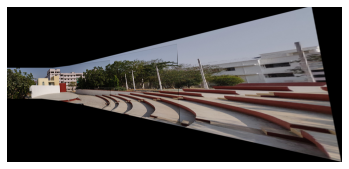

In [19]:
images = [cv.resize(x, dsize=(0, 0), fx=0.3, fy=0.3) for x in read_files_q1(1)]
img = panaroma(images)
show(img)

100%|██████████| 5/5 [00:44<00:00,  8.87s/it]


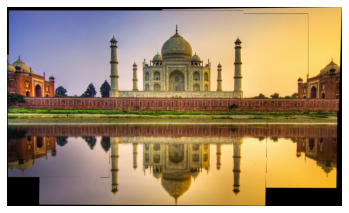

In [20]:
images = read_files_q1(2)
img = panaroma(images)
show(img)

100%|██████████| 1/1 [00:35<00:00, 35.12s/it]


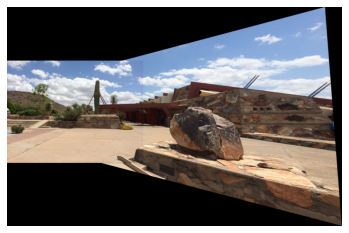

In [21]:
images = read_files_q1(3)
img = panaroma(images)
show(img)

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


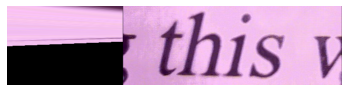

In [24]:
images = read_files_q1(4)
img = panaroma(images)
show(img)

100%|██████████| 3/3 [11:00<00:00, 220.15s/it]


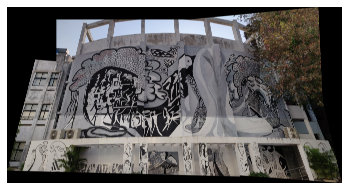

In [23]:
images = read_files_q1(5)
img = panaroma(images)
show(img)

100%|██████████| 1/1 [00:09<00:00,  9.82s/it]


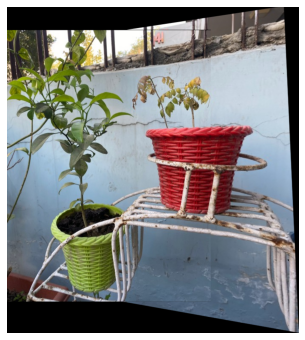

In [25]:
images = read_files_q1(6) # originally contains 2 images
img = panaroma(images)
show(img)

100%|██████████| 2/2 [00:18<00:00,  9.36s/it]


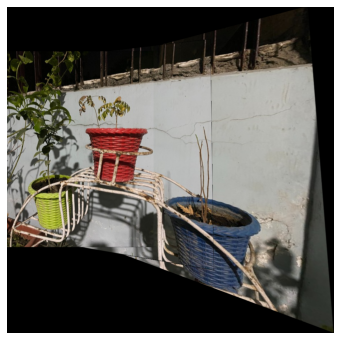

In [35]:
images = read_files_q1(7) # originally contains 3 images of the same scene taken in different lighting conditions
img = panaroma(images)
show(img)

## Question 1 Bonus: Stitching in any order

Stitching images in an order other than the left to right, top to bottom order presents two challenges:
1. In case a pair of images being processed lie far away physically and have little overlap, SIFT would fail to detect enough good correspondences, affecting the quality of homography estimation.
2. In case the first image is not at the top left, several images when transformed into its space would have negative coordinates, which present practical problems with array indexing.

While the second challenge is already solved by our robust stitching algorithm, we must still tackle the first. We do so by aborting the processing of a pair in case SIFT can't find enough correspondences. In case the returned number of matches is lower than a threshold, the image currently being processed is sent to the back of the queue and we continue stitching the next available image with the currently processed mosaic. This is indeed slower and less efficient than simply processing them in order, but that's the price we have to pay for not knowing the order. Here we show the results on image sets 1 and 2 from the dataset, the two sets with the most number of images.

In [7]:
BONUS_THRESH = 100

In [8]:
def stitch_two_bonus(img1_, img2_, thresh): # img1 is new, img2 is base
    '''Stitches two mosaic images out of order.
    '''
    img1 = img1_.copy()
    img2 = img2_.copy()

    points1, points2 = get_matches(img1, img2)
    if len(points1) < thresh:
        return

    H = find_homography_ransac(points1, points2)
    
    width, height, min_point = get_dim(img1, H, img2)
    T = np.array([
        [1, 0, -min_point[0]],
        [0, 1, -min_point[1]],
        [0, 0,             1],
    ])

    img1_ = cv.warpPerspective(img1, T @ H, (width, height))
    img2_ = cv.warpPerspective(img2, T, (width, height))
    return overlap(img1_, img2_)

def panaroma_bonus(images_, thresh=BONUS_THRESH):
    '''Stitches multiple mosaic images, out of order.'''
    images = deque(images_)
    if len(images) == 0:
        return
    
    base = images[0]
    images.popleft()
    while len(images) > 0:
        img = images[0]
        images.popleft()

        res = stitch_two_bonus(img, base, thresh)
        if res is None:
            print('-', end='')
            images.append(img)
        else:
            base = crop(res)
        
    return base

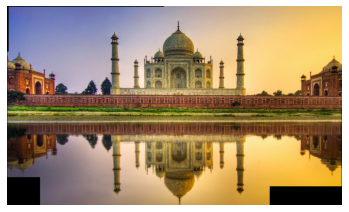

In [14]:
images = read_files_q1(2)
random.shuffle(images)
img = panaroma_bonus(images)
show(img)

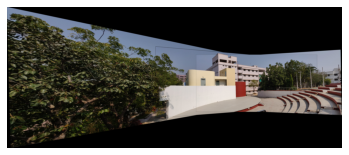

In [40]:
images = [cv.resize(x, dsize=(0, 0), fx=0.3, fy=0.3) for x in [read_files_q1(1)[2], read_files_q1(1)[1], read_files_q1(1)[0], read_files_q1(1)[3]]]
random.shuffle(images)
img = panaroma_bonus(images)
show(img)

# Question 2

Here, we tackle the problem of finding stereo correspondences, that is to find corresponding points between two images of the same scene. Unlike before, the two images are no longer related by a homography (as the world isn't planar and the camera was both rotated and translated), and hence contain information not contained in the other (which can, for example, be used to compute a disparity map and estimate depth).

## Question 2.1

In the first part, we use a simple **intensity window based correlation** to sparsely match pixels in the two images. Given a set of (randomly generated) points in the first image, for every point, we define the set of candidate points to be a large window around the same location in the second image. For every such candidate point, we compute the correlation of the normalised intensity of a small neighbourhood around that point with the normalised intensity of the similar-sized neighbouhood around the target point, and pick the candidate with the maximum correlation. The size of the candidate window (or search space) is based on as estimate of how much the camera has moved. This method is not invariant to rotation, translation, scaling or most other geometric and photometric variations.

In [9]:
SEARCH_SIZE = 25
WINDOW_SIZE = 5
NUM_POINTS = 20

In [10]:
def correlation(win1_, win2_):
    '''
    Assuming win1 and win2 are black and white, finds the normalised intensity based
    correlation between them.
    '''
    if win1_.ndim != 2 or win1_.shape != win2_.shape:
        raise ValueError('Arguments must be 2D arrays of equal sizes.')

    win1 = win1_ - np.mean(win1_)
    win2 = win2_ - np.mean(win2_)

    num = np.sum(win1 * win2)
    den = np.sqrt(np.sum(win1 ** 2) * np.sum(win2 ** 2)) + 1e-3
    return num/den

def GenCoords(x_range, y_range):
    '''
    Generates random, unique coordinates in a range.
    '''
    seen = set()

    x, y = random.randint(*x_range), random.randint(*y_range)

    while True:
        seen.add((x, y))
        yield (x, y)
        x, y = random.randint(*x_range), random.randint(*y_range)
        while (x, y) in seen:
            x, y = random.randint(*x_range), random.randint(*y_range)

def get_safe_points(shape1, shape2, buffer, num):
    '''
    Generates random points win a range, leaving buffer space around.
    '''
    row_range = (buffer + 1, min(shape1[0], shape2[0]) - buffer)
    col_range = (buffer + 1, min(shape1[1], shape2[1]) - buffer)

    coords = []
    g = GenCoords(row_range, col_range)
    for _ in range(num):
        coords.append(next(g))
    return coords

def get_corr_match(neigh, search_space, win_sz):
    '''Searches a search space for the best correlation match of a point.
    '''
    best_point = None
    best_corr = -1

    for i in range(win_sz, search_space.shape[0] - win_sz):
        for j in range(win_sz, search_space.shape[1] - win_sz):
            corr = correlation(neigh, search_space[i-win_sz:i+win_sz, j-win_sz:j+win_sz])
            # print(corr)
            if corr >= best_corr:
                best_corr = corr
                best_point = (i, j)
    return best_point

def intensity_window_correlation(pair_, num=NUM_POINTS, search_sz=SEARCH_SIZE, win_sz=WINDOW_SIZE):
    '''Performs intensity window based correlation stereo matching.'''
    pair = StereoPair(cv.cvtColor(pair_.left, cv.COLOR_RGB2GRAY), cv.cvtColor(pair_.right, cv.COLOR_RGB2GRAY))
    
    buffer = search_sz + win_sz
    left_pts = get_safe_points(pair.left.shape, pair.right.shape, buffer, num)
    right_pts = []

    for (i, j) in left_pts:
        neigh = pair.left[i-win_sz:i+win_sz, j-win_sz:j+win_sz]
        search_space = pair.right[i-buffer:i+buffer, j-buffer:j+buffer]
        selected = get_corr_match(neigh, search_space, win_sz)
        selected = (selected[0] + i - buffer, selected[1] + j - buffer)
        right_pts.append(selected)

    left_pts = np.array(left_pts)
    right_pts = np.array(right_pts)

    fig, (axl, axr) = show(pair_, False)
    colors = np.random.uniform(low=0, high=1, size=left_pts.shape[0])
    axl.scatter(left_pts[:, 1], left_pts[:, 0], s=15, alpha=0.8, cmap='rainbow', c=colors)
    axr.scatter(right_pts[:, 1], right_pts[:, 0], s=15, alpha=0.8, cmap='rainbow', c=colors)
    plt.show()
    


Here we show the results of intensity based window correlation on the three images in the dataset. We note that the method works well on the first image set, which has a small baseline. However, results on the second and third image sets are relatively poor, because of the large displacements. Increasing the window size does improve the results, however it also increases the changes of false matches, as is visible in the second and third image sets, especially with the kind of repeating patterns (minarets, domes and paintings, esges) they have.

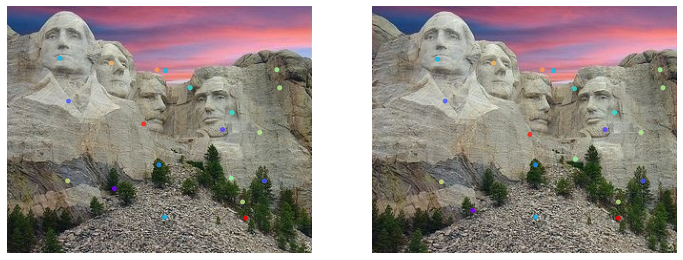

CPU times: user 2.26 s, sys: 3.32 ms, total: 2.26 s
Wall time: 2.26 s


In [44]:
%%time
intensity_window_correlation(read_files_q2(1))

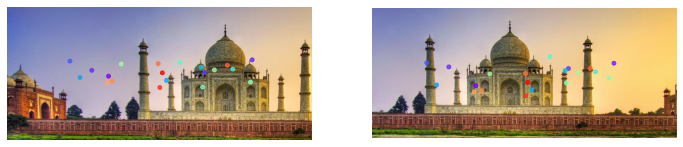

CPU times: user 13.2 s, sys: 45 ms, total: 13.2 s
Wall time: 13.1 s


In [55]:
%%time
intensity_window_correlation(read_files_q2(2), win_sz=100)

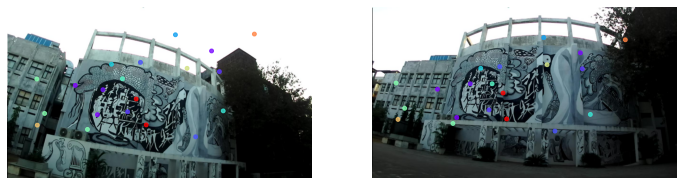

CPU times: user 5.37 s, sys: 59 ms, total: 5.42 s
Wall time: 5.36 s


In [51]:
%%time
intensity_window_correlation(read_files_q2(3), win_sz=50)

## Question 2.2

Here we plot the epipolar lines corresponding to some of the feature points returned by SIFT (we avoid the use of the stereo matches found earlier, to improve results (see Q2.5) and to avoid making the problem of finding stereo matches upon rectification circular by using stereo matches to rectify (see Q2.3)). Using corresponding points, we are able to estimate the **fundamental matrix** between the stereo pair. We further compute the epipolar lines in the other image corresponding to every point in the first image (by simply multiplying the points with the fundamental matrix) and vice versa and plot them for visualisation.

In [11]:
NUM_LINES = 15

In [12]:
def get_fundamental_matrix(pair):
    '''Estimates the fundamental matrix using SIFT correspondences.'''
    left_pts, right_pts = get_matches(pair.left, pair.right)
    # print(left_pts.shape, right_pts.shape)
    F, mask = cv.findFundamentalMat(left_pts, right_pts, cv.FM_LMEDS)
    # return F, left_pts[mask.ravel() == 1], right_pts[mask.ravel() == 1]
    return F, left_pts, right_pts

def abcline(params, axs):
    if not np.isclose(params[1], 0):
        slope = -params[0] / params[1]
        intercept = -params[2] / params[1]

        x_vals = np.array(axs.get_xlim())
        y_vals = intercept + slope * x_vals
        
    elif not np.isclose(params[0], 0):
        x_vals = np.array([-params[2]/params[0]] * 2)
        y_vals = np.array(axs.get_ylim())
    else:
        raise ValueError('Invalid Line.')
    
    axs.autoscale(False)
    axs.plot(x_vals, y_vals, '-')
    return axs

def cvline(params, width):
    a, b, c = params
    
    x = [0, int(width)]
    y = [int((-a * i / b) - (c / b)) for i in x]

    ret = list(zip(x, y))
    return np.array(ret)

def get_colors(n):

    colors = [
        (1,100,211),
        (174,212,46),
        (100,52,183),
        (85,188,47),
        (190,97,233),
        (1,197,87),
        (226,89,219),
        (0,153,32),
        (232,42,163),
        (107,221,136),
        (248,44,151),
        (0,117,48),
        (177,124,255),
        (222,164,0),
        (122,126,255),
        (252,147,20),
        (70,68,175),
        (168,147,0),
        (117,48,164),
        (177,209,131),
        (179,0,135),
        (1,219,210),
        (232,11,80),
        (13,217,245),
        (255,122,39),
        (0,96,179),
        (208,92,0),
        (3,184,242),
        (163,46,0),
        (133,160,255),
        (188,102,0),
        (235,135,255),
        (59,92,26),
        (255,98,193),
        (1,147,107),
        (210,0,107),
        (127,216,174),
        (255,71,89),
        (1,98,150),
        (255,135,71),
        (149,181,255),
        (128,111,0),
        (254,161,255),
        (236,192,99),
        (121,55,134),
        (210,200,126),
        (155,20,106),
        (255,157,100),
        (76,75,142),
        (130,66,0),
        (212,187,252),
        (164,19,40),
        (76,117,165),
        (145,52,27),
        (249,172,245),
        (128,64,53),
        (255,141,215),
        (255,153,127),
        (134,50,111),
        (240,167,158),
        (146,44,84),
        (180,145,195),
        (255,103,163),
        (129,72,105),
        (255,159,165),
        (255,165,200),
        (0, 0, 0),
    ]
    n = n % len(colors)
    return colors[n]

def plot_epipolar_lines(pair, left_pts_, right_pts_, F, num=NUM_LINES):
    
    # indices = np.random.choice(left_pts_.shape[0], size=num, replace=False)
    left_pts = left_pts_[:num]
    right_pts = right_pts_[:num]

    left_pts_h = to_homogenous(left_pts)
    right_pts_h = to_homogenous(right_pts)

    right_lines = (F   @  left_pts_h.T).T
    left_lines  = (F.T @ right_pts_h.T).T
    # each row is a line now

    left_image = pair.left.copy()
    for i, line in enumerate(left_lines):
        # abcline(line, axl)
        points = cvline(line, pair.left.shape[1])
        left_image = cv.line(left_image, (points[0, 0], points[0, 1]), (points[1, 0], points[1, 1]), get_colors(i), 2)
    
    right_image = pair.right.copy()
    for i, line in enumerate(right_lines):
        # abcline(line, axr)
        points = cvline(line, pair.right.shape[1])
        right_image = cv.line(right_image, (points[0, 0], points[0, 1]), (points[1, 0], points[1, 1]), get_colors(i), 2)

    for i, point in enumerate(left_pts):
        left_image = cv.circle(left_image, (int(point[0]), int(point[1])), 4, get_colors(i+30), thickness=-1)
    for i, point in enumerate(right_pts):
        right_image = cv.circle(right_image, (int(point[0]), int(point[1])), 4, get_colors(i+30), thickness=-1)

    pair_plotted = StereoPair(left_image, right_image)
    return pair_plotted


Notice the good quality of fundamental matrix estimation and epipolar line plotting, made possible by robust SIFT correspondences.

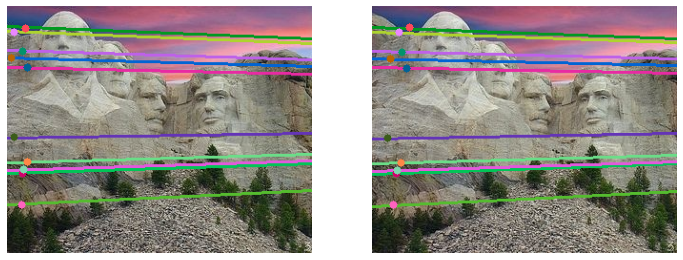

In [58]:
pair = read_files_q2(1)
F, left_pts, right_pts = get_fundamental_matrix(pair)
pair = plot_epipolar_lines(pair, left_pts, right_pts, F, 10)
show(pair)

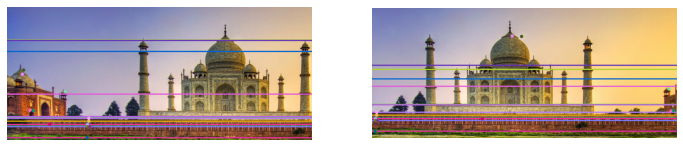

In [59]:
pair = read_files_q2(2)
F, left_pts, right_pts = get_fundamental_matrix(pair)
pair = plot_epipolar_lines(pair, left_pts, right_pts, F, 15)
show(pair)

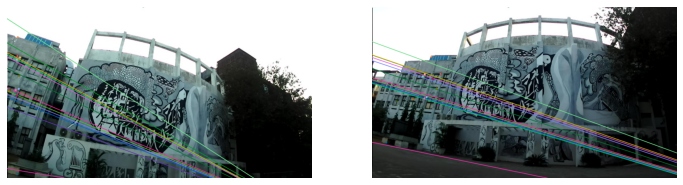

In [61]:
pair = read_files_q2(3)
F, left_pts, right_pts = get_fundamental_matrix(pair)
pair = plot_epipolar_lines(pair, left_pts, right_pts, F, 15)
show(pair)

## Question 2.3 and 2.4

Here, we revisit the problem of finding stereo correspondences using stereo rectification and greedy matching.  
Using the fundamental matrix and correspondences estimated earlier, we are able to rectify the two images, that is, compute two homographies that make the image planes (and the epipolar lines) parallel to each other.  

Now, because the two correspondening points always lie on corresponding epipolar lines (which in this case are aligned and horizontal), the search space for the correspondening point reduces to the same row in the other image. We can use this drastically reduced search space to greedily perform dense matching, using the same intensity based window correlation approach discussed earlier. However, the chances of spurious matches are now much lower and the algorithm runs much faster due to the reduced search space.


In [13]:
def find_transformed_size(H, shape):
    corners = np.array([
        [0,               0],
        [0,        shape[0]],
        [shape[1], shape[0]],
        [shape[1],        0],
    ], dtype=np.float64)
    
    corners = project_points(H, corners)
    width  = int(np.ceil(np.max(corners[:, 0]) - np.min(corners[:, 0])))
    height = int(np.ceil(np.max(corners[:, 1]) - np.min(corners[:, 1])))
    return width, height


def stereo_rectify(pair_, F, left_pts, right_pts):
    # crop to same size
    height = min(pair_.left.shape[0], pair_.right.shape[0])
    width  = min(pair_.left.shape[1], pair_.right.shape[1])
    pair = StereoPair(pair_.left.copy()[:height, :width], pair_.right.copy()[:height, :width])

    # compute homography
    _, H_left, H_right = cv.stereoRectifyUncalibrated(left_pts, right_pts, F, (width, height))
    left_size  = find_transformed_size(H_left, pair.left.shape)
    right_size = find_transformed_size(H_right, pair.right.shape)

    rect_left = crop(cv.warpPerspective(pair.left, H_left, left_size))
    rect_right = crop(cv.warpPerspective(pair.right, H_right, right_size))

    return StereoPair(rect_left, rect_right)


Here, we show the stereo-rectified images. Notice the parallel epipolar lines.

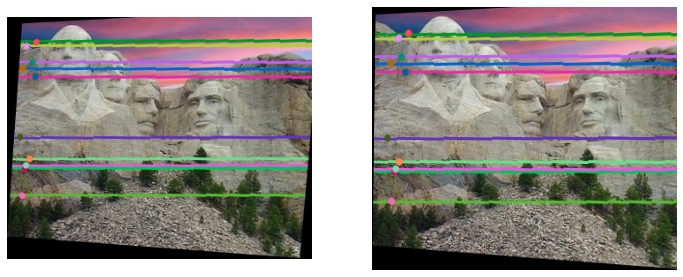

In [63]:
pair = read_files_q2(1)
F, left_pts, right_pts = get_fundamental_matrix(pair)
pair = plot_epipolar_lines(pair, left_pts, right_pts, F, 10)
pair = stereo_rectify(pair, F, left_pts, right_pts)
show(pair)

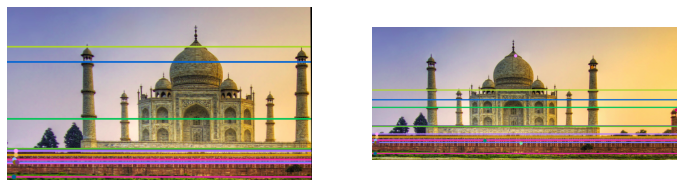

In [64]:
pair = read_files_q2(2)
F, left_pts, right_pts = get_fundamental_matrix(pair)
pair = plot_epipolar_lines(pair, left_pts, right_pts, F, 15)
pair = stereo_rectify(pair, F, left_pts, right_pts)
show(pair)

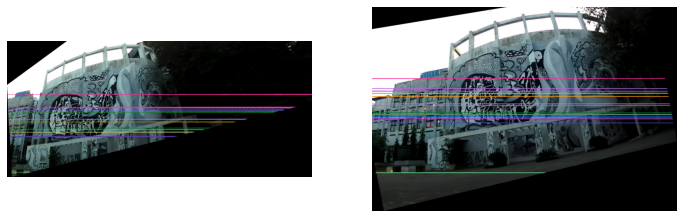

In [71]:
pair = read_files_q2(3)
F, left_pts, right_pts = get_fundamental_matrix(pair)
pair = plot_epipolar_lines(pair, left_pts, right_pts, F, 20)
pair = stereo_rectify(pair, F, left_pts, right_pts)
show(pair)

In [14]:
def intensity_window_correlation_greedy(pair_, num=NUM_POINTS, win_sz=WINDOW_SIZE):
    pair = StereoPair(cv.cvtColor(pair_.left, cv.COLOR_RGB2GRAY), cv.cvtColor(pair_.right, cv.COLOR_RGB2GRAY))

    left_pts = get_safe_points(pair.left.shape, pair.right.shape, win_sz+1, num)
    right_pts = []

    for (i, j) in left_pts:
        neigh = pair.left[i-win_sz:i+win_sz, j-win_sz:j+win_sz]
        search_space = pair.right[i-win_sz:i+win_sz+1, win_sz:-win_sz]
        selected = get_corr_match(neigh, search_space, win_sz)
        selected = (selected[0] + i - win_sz, selected[1] + win_sz)
        right_pts.append(selected)
    
    left_pts = np.array(left_pts)
    right_pts = np.array(right_pts)

    fig, (axl, axr) = show(pair_, False)
    colors = np.random.uniform(low=0, high=1, size=left_pts.shape[0])
    axl.scatter(left_pts[:, 1], left_pts[:, 0], s=15, alpha=0.8, cmap='rainbow', c=colors)
    axr.scatter(right_pts[:, 1], right_pts[:, 0], s=15, alpha=0.8, cmap='rainbow', c=colors)
    plt.show()


Here, we show the results of greedy matching for a few randomly selected points. Notice the extremely good quality of the results, especially in image set 2 (The Taj Mahal Complex in Agra, India) where almost all points have been correctly matches, despite the repeating patterns and large camera baseline.

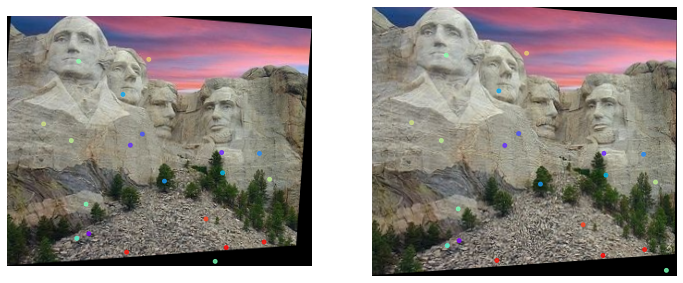

CPU times: user 576 ms, sys: 149 ms, total: 724 ms
Wall time: 448 ms


In [73]:
%%time
pair_1 = read_files_q2(1)
F, left_pts, right_pts = get_fundamental_matrix(pair_1)
pair_1 = stereo_rectify(pair_1, F, left_pts, right_pts)
intensity_window_correlation_greedy(pair_1)

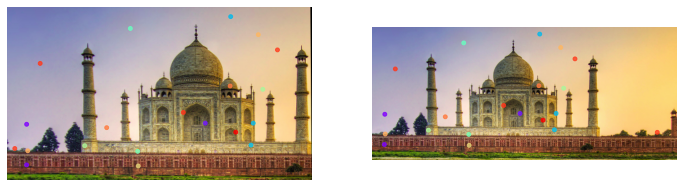

CPU times: user 1.43 s, sys: 65.2 ms, total: 1.49 s
Wall time: 888 ms


In [74]:
%%time
pair_1 = read_files_q2(2)
F, left_pts, right_pts = get_fundamental_matrix(pair_1)
pair_1 = stereo_rectify(pair_1, F, left_pts, right_pts)
intensity_window_correlation_greedy(pair_1)

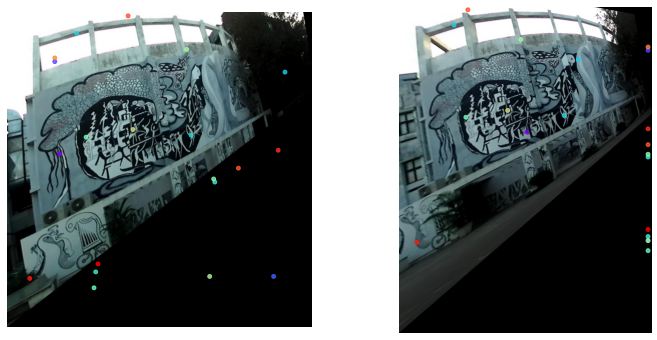

CPU times: user 1min 20s, sys: 13min 58s, total: 15min 19s
Wall time: 1min 14s


In [80]:
%%time
pair_1 = read_files_q2(3)
F, left_pts, right_pts = get_fundamental_matrix(pair_1)
pair_1 = stereo_rectify(pair_1, F, left_pts, right_pts)
intensity_window_correlation_greedy(pair_1)

**Note:** *Spurious matches in the above image occur when the randomly selected point lies in the empty space. The points that actually lie on the image have been matched relatively well.*

In order to compare the brute force and greedy matching, we use two factors:
1. **Algorithm Run Time:** The times printed above clearly show that in most cases, the greedy approach is much faster, even when including the time required to find SIFT correspondences (while SIFT is usually slow and processing intensive), stereo-rectify the image and then search for stereo correspondences. The greedy approach (including the preprocessing time) usually takes of the order of a few 100 milliseconds, while the brute force approach (without the need for preprocessing) takes about a few seconds to run. The greedy approach becomes slow in case of image set 3 due to the time taken by SIFT (and random processor load).
2. **Match Quality:** A quick visual inspection clearly shows the superior matches produced by the greedy algorithm, due to its smaller search space, and mathematical guarantee of the match lying in that search space. The results are especially noticeable in image set 2.

## Question 2 Bonus: Using SIFT

In the above discussion, we used SIFT features to compute the fundamental matrix. To compare, here we use the stereo correspondences originally obtained in question 2.1 using brute force intensity window based correlation for the same purpose. We notice that while the results aren't terribly inaccurate, they aren't as good as those obtained with SIFT, due to the poorer accuracy of the matches and hence of the estimated fundamental matrix.

In [31]:
def bonus_intensity_window_correlation(pair_, num=NUM_POINTS, search_sz=SEARCH_SIZE, win_sz=WINDOW_SIZE):
    pair = StereoPair(cv.cvtColor(pair_.left, cv.COLOR_RGB2GRAY), cv.cvtColor(pair_.right, cv.COLOR_RGB2GRAY))
    
    buffer = search_sz + win_sz
    left_pts = get_safe_points(pair.left.shape, pair.right.shape, buffer, num)
    right_pts = []

    for (i, j) in left_pts:
        neigh = pair.left[i-win_sz:i+win_sz, j-win_sz:j+win_sz]
        search_space = pair.right[i-buffer:i+buffer, j-buffer:j+buffer]
        selected = get_corr_match(neigh, search_space, win_sz)
        selected = (selected[0] + i - buffer, selected[1] + j - buffer)
        right_pts.append(selected)

    left_pts = np.array(left_pts)
    right_pts = np.array(right_pts)

    return left_pts, right_pts

def bonus_get_fundamental_matrix(pair):
    left_pts, right_pts = bonus_intensity_window_correlation(pair, num=100)
    left_pts = left_pts[:, ::-1]
    right_pts = right_pts[:, ::-1]
    # print(left_pts.shape, right_pts.shape)
    F, mask = cv.findFundamentalMat(left_pts, right_pts, cv.FM_LMEDS)
    # return F, left_pts[mask.ravel() == 1], right_pts[mask.ravel() == 1]
    return F, left_pts, right_pts

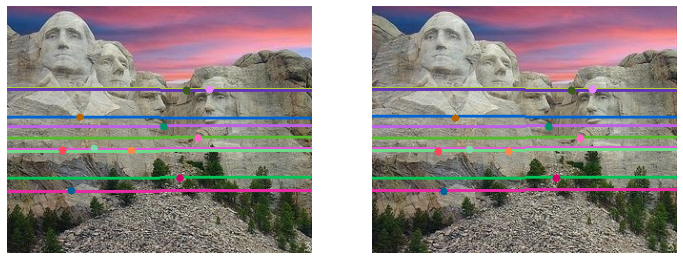

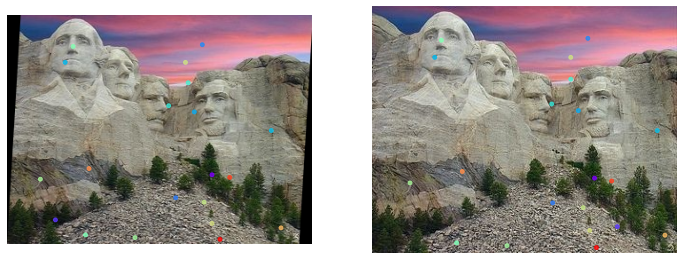

In [34]:
pair = read_files_q2(1)
F, left_pts, right_pts = bonus_get_fundamental_matrix(pair)
pair_ = plot_epipolar_lines(pair, left_pts, right_pts, F, 10)
show(pair_)
pair = stereo_rectify(pair, F, left_pts, right_pts)
intensity_window_correlation_greedy(pair)

We have first plotted the epipolar lines we obtain for the randomly selected points (and their brute force intensity window based correlation matches) that were used to estimate the fundamental matrix. Then, we show the stereo correspondences obtained after rectifying the image using this fundamental matrix and performing greedy matching, for a new set of random points.